In [ ]:
import numpy as np
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Aqui eu carrego os dados gerados anteriormente


In [ ]:
Dado = np.load('/content/drive/MyDrive/Colab Notebooks/15-02-2022/valoresInterpolados.npy')

In [ ]:
np.max(Dado)

0.42492004797522065

In [ ]:
np.min(Dado)

0.0

In [ ]:
Dado.shape

(384, 36, 15, 1)

* Divisão do meu dataset em treino, validação e teste

In [ ]:
hdf = h5py.File('data.h5', 'w')
hdf.create_dataset('Treino', data = Dado)
hdf.create_dataset('Validacao', data = Dado)
hdf.create_dataset('Teste', data = Dado)

hdf.close()

In [ ]:
def LerH5(DATA,Chave):
    import h5py
    import os.path as path
    import numpy as np  
    if path.exists(DATA):
        with h5py.File(DATA,'r') as f:
            real = f[Chave][...]

    return(real)

In [ ]:
def ExtrairChaves(DATA):
    import h5py
    import os.path as path
    import numpy as np  
    if path.exists(DATA):
        f = h5py.File(DATA, 'r')
        return(f.keys() )
    #return(real)

In [ ]:
ExtrairChaves('data.h5')

<KeysViewHDF5 ['Teste', 'Treino', 'Validacao']>

In [ ]:
Treino=LerH5('data.h5','/Treino')
Validacao=LerH5('data.h5','/Validacao')
Teste=LerH5('data.h5','/Teste')

In [ ]:
Teste.shape

(384, 36, 15, 1)

In [ ]:
dados = np.concatenate([Treino, Validacao, Teste])

In [ ]:
treinamento_x, validacao_x = train_test_split(dados, test_size=0.3)

In [ ]:
validacao_x, teste_x = train_test_split(dados, test_size=0.5)

In [ ]:
treinamento_y = treinamento_x
validacao_y = validacao_x
teste_y = teste_x

In [ ]:
temp_pattern = 10 #quantas medidas passadas serão usadas para prever as medidas para frente
batch_size = 1 #corresponde ao valor de amostras que serão processadas em conjunto durante o processo de optimização
NumeroDeModelos = 1 #atributos utilizados

In [ ]:
#Modelo
from keras.models import Sequential
from keras.layers import ConvLSTM2D,BatchNormalization,Conv3D

model = Sequential([
ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(None, 36, 15, NumeroDeModelos), padding='same', return_sequences=True, use_bias=True),#padding='same' -> mesma estrutura de entrada e saida, não perde dimensão no espaço
BatchNormalization(),

ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, use_bias=True, recurrent_dropout=.5),
BatchNormalization(),

Conv3D(filters=1, kernel_size=(3,3,3), padding='same', data_format='channels_last')#conv (espaço, espaço, canais) -> data_format='channels_last'
])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 36, 15, 32)  38144     
                                                                 
 batch_normalization_2 (Batc  (None, None, 36, 15, 32)  128      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 36, 15, 64)  221440    
                                                                 
 batch_normalization_3 (Batc  (None, None, 36, 15, 64)  256      
 hNormalization)                                                 
                                                                 
 conv3d_1 (Conv3D)           (None, None, 36, 15, 1)   1729      
                                                                 
Total params: 261,697
Trainable params: 261,505
Non-tr

In [ ]:
#A seguir temos o gerador que ira refazer o mapeamento do tensor de 3 dimensoes em 5
#Com isto podemos passar os dados para o modelo ser treinado sem significante custo de memoria
#Este recebe como parametros o tensor de treinamento, 
                        #o numero de medidas temporais
                        #O numero de amostras a serem geradas em um batch
def myGeneratorT(data, temp_pattern, batch_size=1):
    print(data.shape)
    while 1 :
        for i in range(int(data.shape[0]/batch_size)-temp_pattern-batch_size):
          j = i*batch_size
          for b in range(batch_size):
            train_X = np.zeros((1,temp_pattern,data.shape[1],data.shape[2],1),dtype=float)
            train_Y = np.zeros((1,temp_pattern,data.shape[1],data.shape[2],1),dtype=float)
            train_X[0,:,:,:,:] = data[(j+b):(j+b)+temp_pattern,:,:]
            train_Y[0,:,:,:,:] = data[(j+b+1):(j+b+1)+temp_pattern,:,:]
            if b == 0:
              X = train_X
              Y = train_Y
            else:
              X = np.concatenate((X,train_X), axis=0)
              Y = np.concatenate((Y, train_Y), axis=0)
          yield X, Y #retorna em demanda vai salvando o estado (gerador permite isso)

In [ ]:
Treino.shape

(384, 36, 15, 1)

In [ ]:
from keras.callbacks import ModelCheckpoint

EPOCHS=20

mc = ModelCheckpoint('best_Model_2.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
callbacks = [mc]


H = model.fit_generator(myGeneratorT(Treino
                                     ,temp_pattern), steps_per_epoch=Treino.shape[0]/2, 
                        validation_data=(myGeneratorT(Validacao
                                                      ,temp_pattern)), 
                        validation_steps=Validacao.shape[0]/2, callbacks=callbacks, epochs = EPOCHS, verbose=1)

(384, 36, 15, 1)
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


192/192 [==============================] - ETA: 0s - loss: 0.0476 - mse: 0.0476(384, 36, 15, 1)

Epoch 1: val_loss improved from inf to 0.00346, saving model to best_Model_2.h5
192/192 [==============================] - 103s 508ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/20
192/192 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015
Epoch 2: val_loss improved from 0.00346 to 0.00104, saving model to best_Model_2.h5
192/192 [==============================] - 99s 516ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 3/20
192/192 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 3: val_loss did not improve from 0.00104
192/192 [==============================] - 104s 542ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/20
192/192 [==============================] - ETA: 0s - loss: 7.8193e-04 - mse: 7.8193e-04
Epoch 4: val_loss improved from 0.001

In [ ]:
from keras.models import load_model
Modelo=load_model('best_Model_2.h5')
Modelo.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
#Treino
Modelo.evaluate_generator(myGeneratorT(Treino,temp_pattern, batch_size),workers=1, use_multiprocessing=False, steps=Treino.shape[0],verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


(384, 36, 15, 1)
384/384 [==============================] - 36s 91ms/step - loss: 3.3337e-04 - mse: 3.3337e-04


[0.00033336805063299835, 0.0003333685453981161]

In [ ]:
#Validacao
Modelo.evaluate_generator(myGeneratorT(Validacao,temp_pattern, batch_size),workers=1, use_multiprocessing=False, steps=Validacao.shape[0],verbose=1)

(384, 36, 15, 1)
  1/384 [..............................] - ETA: 49s - loss: 4.1005e-04 - mse: 4.1005e-04

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


384/384 [==============================] - 35s 91ms/step - loss: 3.3337e-04 - mse: 3.3337e-04


[0.00033336805063299835, 0.0003333685453981161]

In [ ]:
#Teste
Modelo.evaluate_generator(myGeneratorT(Teste,temp_pattern, batch_size),workers=1, use_multiprocessing=False, steps=Teste.shape[0],verbose=1)

(384, 36, 15, 1)
  1/384 [..............................] - ETA: 45s - loss: 4.1005e-04 - mse: 4.1005e-04

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


384/384 [==============================] - 35s 91ms/step - loss: 3.3337e-04 - mse: 3.3337e-04


[0.00033336805063299835, 0.0003333685453981161]

In [ ]:
k=30

In [ ]:
Prev=Modelo.predict_generator(myGeneratorT(Teste[0:k:,:,:],10, 1),workers=1, use_multiprocessing=False, steps=Teste[0:k:,:,:].shape[0])

(30, 36, 15, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
Prev.shape

(30, 10, 36, 15, 1)

In [ ]:
Previsao=Prev[:,-1,:,:]

In [ ]:
Real=Teste[temp_pattern:(temp_pattern+k),:,:]

In [ ]:
Real.shape

(30, 36, 15, 1)

In [ ]:
Previsao.shape=(k,36,15,1)

associação do erro com o valor da medida, correlação do erro e valor medida em relação ao tempo, quais os pontos espaciais q tem < e > erro

Calculando os residuals da previsao de chuva e os visualizando

In [ ]:
Residuals=np.abs(Previsao-Real)

In [ ]:
Residuals[0,:,:,0].reshape(-1).shape

(540,)

In [ ]:
Previsao[0,:,:,0].reshape(-1).shape

(540,)

* 1 analise: como o modelo se comporta pra prever a quantidade de chuva ignorando escala quando n tem uma correlação tendendo a 1 (mais interessante) LISTA 1
* 2 analise do erro relativo: trato a escala, ainda esta tendo o efeito de maior a medida maior o erro? (valor real muito pewueno, erro alto) LISTA 2
* 3 analise: eliminar o risco do 0 influenciar a decisao, (confiança q vai chover só n sabe a quantidade), usamos o logico para ver quando vai chover no instante de tempo

In [ ]:
#erro absoluto (nao faz a normalização)
np.corrcoef(Residuals[0,:,:,0].reshape(-1), Real[0,:,:,0].reshape(-1))

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

In [ ]:
lista = []
for i in range(Residuals.shape[0]):  
  lista.append((np.corrcoef((Residuals/(Real + 10**(-4)))[i,:,:,0].reshape(-1), Real[i,:,:,0].reshape(-1)))[0,1])

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
lista

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.026740703196259125,
 0.05048237426563499,
 0.11587141588050737,
 -0.16020988470155292,
 -0.3378276736503753,
 -0.06373819404509316,
 0.17328276067614273,
 0.039489854729695975,
 -0.16220891118260836,
 0.04054792443093465,
 0.09260602811936916,
 0.07646127950598318,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
lista2 = []
for i in range(Real.shape[0]):  #for i in range(Residuals.shape[0]):
  a = Real[i,:,:,0].reshape(-1)
  logico = a>0

  b = (Real[i,:,:,0].reshape(-1)) # b = (Residuals[i,:,:,0].reshape(-1))
  b = b/(a+10**(-4))
  b = b[logico]

  c = Previsao[i,:,:,0].reshape(-1)
  c = c[logico]

  lista2.append(np.corrcoef(c, b)[0,1])

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


quando preve valor pequeno o erro relativo é muito grande, quando preve valor grande o erro relativo é pequeno
(mais confiavel com grandes)

modelo captura o efeito mas n totalemnte, a partir do momento q tem chuva, quando n tem chuva e me devolve um valor constante(n da pra saber se é =0 ou n)


In [ ]:
#quanto menor a medida maior o erro
#superestimou chuva
lista2

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.02674037052563029,
 -0.05048298704527551,
 -0.07307793100963844,
 -0.1594607814338085,
 -0.33628612231003685,
 -0.11974018273229534,
 0.07725564422563778,
 0.1563602293150928,
 0.036159272056852994,
 -0.09224267803805401,
 0.026740766677665506,
 0.02674065812266612,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
a.shape

(540,)

In [ ]:
b.shape

(0,)

In [ ]:
Residuals[i].reshape(-1).shape

(540,)

In [ ]:
i=21
a = Real[i,:,:,0].reshape(-1)
logico = a>0

logico

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
lista2 

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.02674037052563029,
 -0.05048298704527551,
 -0.07307793100963844,
 -0.1594607814338085,
 -0.33628612231003685,
 -0.11974018273229534,
 0.07725564422563778,
 0.1563602293150928,
 0.036159272056852994,
 -0.09224267803805401,
 0.026740766677665506,
 0.02674065812266612,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
#erro relativo
Residuals/(Real + 10**(-4))

array([[[[ 459.30661261],
         [  12.5785917 ],
         [ 351.81298852],
         ...,
         [ 363.11894655],
         [ 277.71294117],
         [ 490.0092259 ]],

        [[ 391.43756032],
         [ 267.25307107],
         [ 654.46704626],
         ...,
         [ 466.3579911 ],
         [  59.456788  ],
         [ 359.80150104]],

        [[ 684.39275026],
         [ 344.0759331 ],
         [ 687.36463785],
         ...,
         [ 508.11812282],
         [ 394.75269616],
         [ 374.14703518]],

        ...,

        [[ 652.36590803],
         [ 357.91292787],
         [ 484.588705  ],
         ...,
         [ 463.28283846],
         [ 298.69504273],
         [ 342.01804549]],

        [[1075.68323612],
         [ 926.77563429],
         [ 873.16796184],
         ...,
         [ 711.11008525],
         [ 658.11261535],
         [ 553.07816714]],

        [[ 702.2254169 ],
         [ 867.36008525],
         [1289.15727139],
         ...,
         [1324.35441017],
        

In [ ]:
#erro relativo vs. real

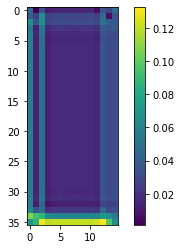

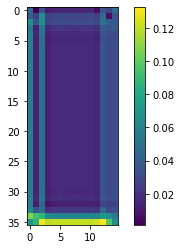

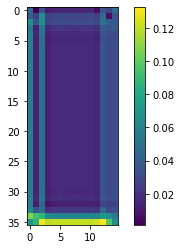

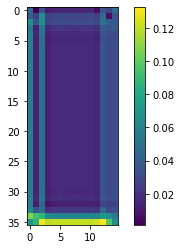

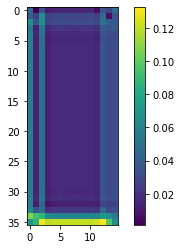

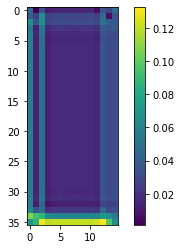

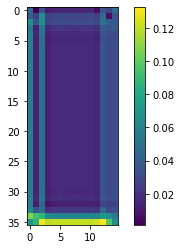

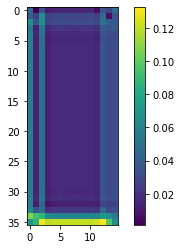

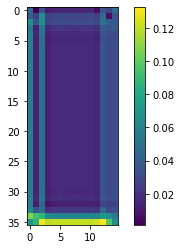

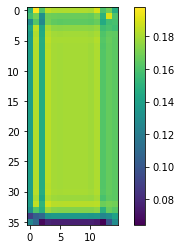

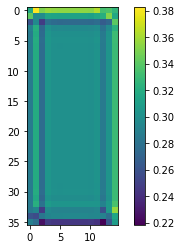

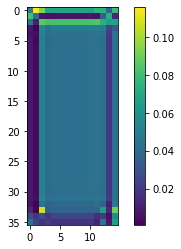

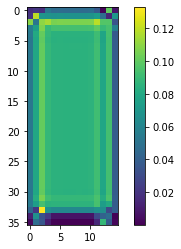

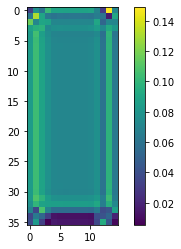

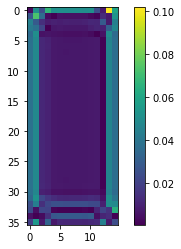

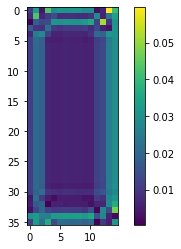

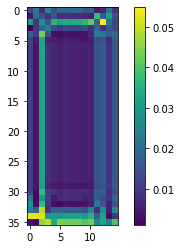

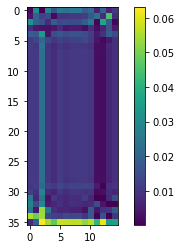

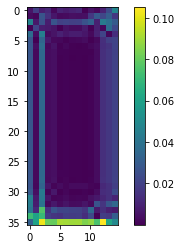

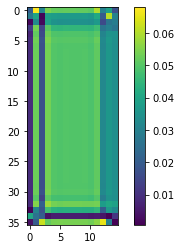

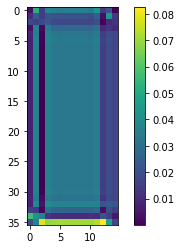

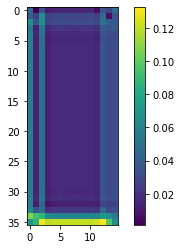

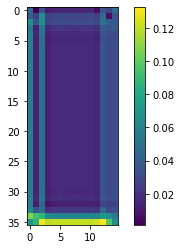

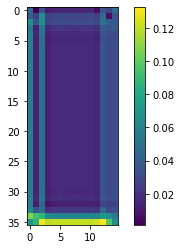

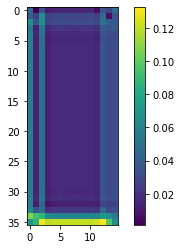

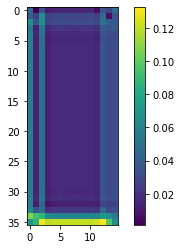

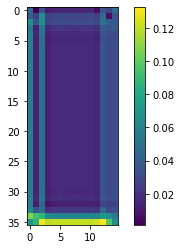

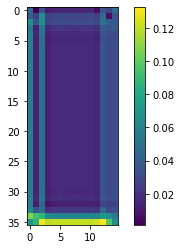

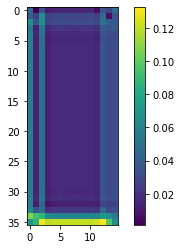

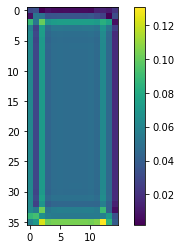

In [ ]:
import matplotlib.pyplot as plt
for i in range(Residuals.shape[0]):
    plt.imshow(Residuals[i,:,:,0])
    plt.colorbar()
    plt.show()

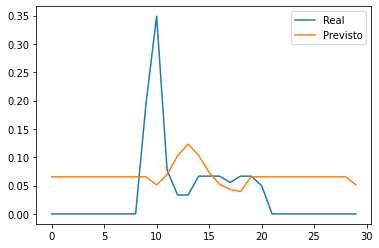

In [ ]:
i,j=1,2
plt.plot(Real[:,i,j,0],label='Real')
plt.plot(Previsao[:,i,j,0],label='Previsto')
plt.legend()